<a href="https://colab.research.google.com/github/Andrey-Mel/recover_from_hidden_space/blob/main/recover_from_hid_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

На базе HorsesOrHumans (которая есть в открытом доступе библиотеки tensorflow) постройте автокодировщик. Предобучите автокодировщик. Возьмите предобученный encoder. Кластеризуйте скрытое пространство на два кластера, полученное из encoder (т.е. кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство).
Проверьте насколько точно произошла кластеризация картинок лошадей и людей по двум классам.


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets.public_api as tfds # библиотека tensorflow для скачивания датасета horses_or_human
from tensorflow.keras.models import Model, Sequential  #загружаем абстрактный класс создания моделей
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, Reshape,Input#подключаем слои кераса
from tensorflow.keras.optimizers import Adam #подключаем оптимайзер
from tensorflow.keras import utils #загружаем утилиты керас
from tensorflow.keras.preprocessing import image #модуль преобразования и отрисовки изображений

#Библиотека для кластеризации
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image #модуль ортисовки изображений
import seaborn as sns

from google.colab import files

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(x_train,_),(x_test,_) = tfds.as_numpy(tfds.load('horses_or_humans',
                                                 split=['train','test'], #делим на обучающую и тестовую выборки
                                                 batch_size=-1,          #загружаем весь батч
                                                 as_supervised=True))    #преобразование в класс numpy.ndarray

In [ ]:
x_train = x_train.astype('float32')/255 #представляем значения ввиде от 0 до 1
x_test = x_test.astype('float32')/255 #представляем значения ввиде от 0 до 1

In [ ]:
print(type(x_train))
print(x_train.shape)
print(x_test.shape)

<class 'numpy.ndarray'>
(1027, 300, 300, 3)
(256, 300, 300, 3)


In [ ]:
#функция отображения
def visual_image(*args):
  args = [x.squeeze() for x in args] #удаляем ось
  n = min([x.shape[0] for x in args])
  plt.figure(figsize=(2*n, 2*len(args)))
  for j in range(n):
    for i in range(len(args)):
      ax = plt.subplot(len(args), n, i*n +j +1)
      plt.imshow(args[i][j])
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show

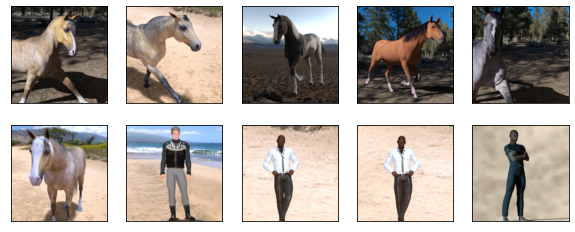

In [ ]:
visual_image(x_train[:6],x_train[12:17])

Сверточный автоэнкодер

In [ ]:

def create_ae_conv(): #функция создания сверточного автоэнкодера
  input_img = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])) #300,300,3

  x = Conv2D(256,(3,3),padding='same', activation='relu')(input_img) #256,300,300,3
  x = MaxPooling2D((2,2))(x) #256,150,150,3
  x = Conv2D(128,(3,3), padding='same', activation='relu')(x) #128,150,150,3
  x = MaxPooling2D((2,2))(x) # 128,75,75,3
  x = Conv2D(64,(3,3),padding='same', activation='relu')(x) #64,75,75,3
  x = MaxPooling2D((3,3))(x) #64,25,25,3
  x = Conv2D(32,(2,2),padding='same', activation='sigmoid')(x) #32,25,25,3
  x = MaxPooling2D((5,5))(x) # 32,5,5,3
  encoded = Conv2D(3,(2,2),padding='same',activation='relu')(x) #1,5,5,3 Финальный слой энкодера

  #Декодер вход 1,5,5,3
  input_decod = Input(shape=(5,5,3)) #вход в декодер
  x = Conv2D(32,(3,3),padding='same', activation='relu')(input_decod) #32,5,5,3
  x = UpSampling2D((5,5))(x) #32,25,25,3
  x = Conv2D(64,(3,3),padding='same',activation='relu')(x) #64,25,25,3
  x = UpSampling2D((3,3))(x) # 64,75,75,3
  x = Conv2D(128,(4,4),padding='same',activation='relu')(x) #128,75,75,3
  x = UpSampling2D((4,4))(x) #128,300,300,3
  decoded = Conv2D(3, (5,5),padding='same', activation='sigmoid', name='end')(x)
  #print(decoded.shape)
  #Модели
  encoder = Model(input_img,encoded, name='encoder') #модель энкодера
  decoder = Model(input_decod, decoded, name='decoder') #декодер модель
  autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')
  return encoder, decoder, autoencoder

#my_encoder,my_decoder,my_autoencoder = create_ae_conv()

In [ ]:
#Создаю три модели: encoder,decoder, autoencoder
my_encoder,my_decoder,my_autoencoder = create_ae_conv()
my_autoencoder.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy') #компиляция полного автоэнкодера

(None, 300, 300, 3)


In [ ]:
my_autoencoder.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy') #компиляция полного автоэнкодера

In [ ]:
my_encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 300, 300, 256)     7168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 150, 150, 256)     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 150, 150, 128)     295040    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0   

In [ ]:
my_autoencoder.fit(x_train, x_train,
                   epochs=20,
                   batch_size = 25,
                   shuffle=True,
                   verbose=1,
                   validation_data=(x_test,x_test))

Epoch 1/20
42/42 [==============================] - 64s 1s/step - loss: 0.5631 - val_loss: 0.2505
Epoch 2/20
42/42 [==============================] - 62s 1s/step - loss: 0.5651 - val_loss: 0.2502
Epoch 3/20
42/42 [==============================] - 62s 1s/step - loss: 0.5651 - val_loss: 0.2503
Epoch 4/20
42/42 [==============================] - 62s 1s/step - loss: 0.5612 - val_loss: 0.2509
Epoch 5/20
42/42 [==============================] - 62s 1s/step - loss: 0.5601 - val_loss: 0.2507
Epoch 6/20
42/42 [==============================] - 62s 1s/step - loss: 0.5640 - val_loss: 0.2505
Epoch 7/20
42/42 [==============================] - 62s 1s/step - loss: 0.5640 - val_loss: 0.2506
Epoch 8/20
42/42 [==============================] - 62s 1s/step - loss: 0.5630 - val_loss: 0.2508
Epoch 9/20
42/42 [==============================] - 62s 1s/step - loss: 0.5615 - val_loss: 0.2507
Epoch 10/20
42/42 [==============================] - 62s 1s/step - loss: 0.5620 - val_loss: 0.2509
Epoch 11/20
42/42 [

In [ ]:
#Сохранение весов автокодировщика
my_autoencoder.save_weights('/content/drive/My Drive/control_test/my_autoencoder.h5')
#my_autoencoder.load_weights('/content/drive/My Drive/control_test/my_autoencoder.h5')

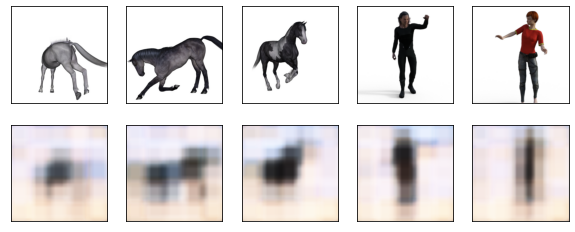

In [ ]:
#Ошибку на графике не вывожу, потому что в автокодировщиках и генеративный созтязательных сетях
#достойной метрики нет, метрика только если увидеть самому конечный результат.
#Посмотрую насколько обучился my_encoder
n=5
image_test = x_test[:n] #выборка
image_pred_encod = my_encoder.predict(image_test) #скрытая часть предсказаная энкодером
image_pred_decod = my_decoder.predict(image_pred_encod) #расшифрованные изображения (в общем проверка автоэнкодера)
visual_image(image_test,image_pred_decod)

Изображения четкими не получились. Надо я думаю дообучать автокодировщик, но так как в задании сказано что за точностью "не гонитесь", я продолжу по заданию дальше. 

Перед кластеризацией на занятиях мы парсили базу, то есть нормализовали данные базы. В моем случае рисунки уже нормализованы перед подачей в автоэнкодер. Все изображения как обучающие так и тестовые поделены на 255, а это значит все значения расположены в диапазоне от 0 до 255. Поэтому я не вижу смысла делать какую-нибудь нормализацию изображений и буду в кластеризацию подавать такими какими выдаст скрытый слой автоэнкодера. После кластеризации я визуализирую полученные результаты функцией visual_image, но только после прогона декодером.

In [ ]:
#Определяю количество изображений которые будут подаваться в энкодер
#Подаю так мало изображений так как пишет ошибку "Ошибка выделения памяти"
k = 55
imag_for_encoder = x_test[:k] #количество изображений для подачи в энкодер
imag_for_claster = my_encoder(imag_for_encoder) #Здесь получу значения скрытого пространства из энкодера и подам в кластеризацию

In [ ]:
#Здесь я вытягиваю в вектор тензоры, которые получили из энкодера, потому что
#в кластеризацию можно подавать только двумерную матрицу
#После получения меток кластеризации я произведу обратно размерность в (55,5,5,3) и подам в декодер
image_for_claster = tf.reshape(imag_for_claster,[k,5*5*3])
print(image_for_claster.shape)
print(type(image_for_claster))

(55, 75)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
#Кластеризация
ClusterCount = 2
kmean = KMeans(ClusterCount)#Создаем объект KMeans
kmean.fit(image_for_claster)#производим кластеризацию данных преобразованных в вектор
labels = kmean.labels_      #получаем метки после кластеризации

In [ ]:
print(image_for_claster[labels == 1])

tf.Tensor(
[[1.1391648  0.45030972 0.29693034 ... 0.7215601  0.73624766 0.        ]
 [1.048216   0.55877835 0.34260803 ... 0.7219312  0.7364899  0.        ]
 [1.0219619  0.54640466 0.18742695 ... 0.72294647 0.7370346  0.        ]
 ...
 [1.0920643  0.49387386 0.34594426 ... 0.72125965 0.73622084 0.        ]
 [1.0768956  0.45721984 0.3294253  ... 0.72206223 0.7365169  0.        ]
 [1.0807735  0.5085614  0.36351192 ... 0.72167134 0.7363441  0.        ]], shape=(34, 75), dtype=float32)


In [ ]:
print(image_for_claster[labels == 0])

tf.Tensor(
[[1.067612   0.50339687 0.35978872 ... 0.74910855 0.7504705  0.        ]
 [1.0175108  0.49783275 0.37616038 ... 0.7641511  0.7567527  0.        ]
 [0.97523403 0.5522552  0.25047368 ... 0.7229466  0.73703456 0.        ]
 ...
 [1.0366127  0.46888307 0.36323473 ... 0.7358157  0.74799085 0.        ]
 [1.0062418  0.4737611  0.32473335 ... 0.68854356 0.7430512  0.        ]
 [0.99181336 0.43300036 0.30642226 ... 0.73570776 0.7447563  0.        ]], shape=(21, 75), dtype=float32)


Вот по полученным данным мы видим что разбились метки на 2 класса: 1 класс-  21 штука с размерностью 75, и 0 класс - 34 вектора с размером тоже 75. Теперь сохраню какой-то класс в переменную, сделаю из вектора тензор и подам в декодер.

In [ ]:
#Перевожу обратно в тензор [-1,5,5,3] с меткой 0
from_claster_0 = image_for_claster[labels == 0]
from_claster_0 = tf.reshape(from_claster_0,[-1,5,5,3])
print('Перевожу обратно в тензор 0 класс: ',from_claster_0.shape)

Перевожу обратно в тензор 0 класс:  (21, 5, 5, 3)


In [ ]:
#Перевожу обратно в тензор [-1,5,5,3] с меткой 1
from_claster_1 = image_for_claster[labels == 1]
from_claster_1 = tf.reshape(from_claster_1,[-1,5,5,3])
print('Перевожу обратно в тензор 1 класс: ',from_claster_1.shape)

Перевожу обратно в тензор 1 класс:  (34, 5, 5, 3)


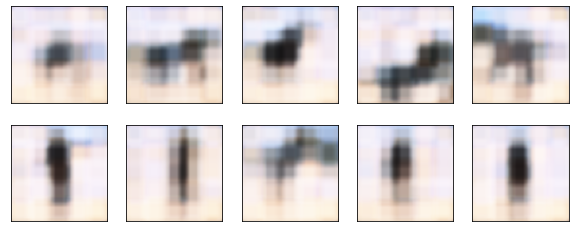

In [ ]:
#Подаю в декодер
from_decoder_0 = my_decoder.predict(from_claster_0[:5])
from_decoder_1 = my_decoder.predict(from_claster_1[:5])
visual_image(from_decoder_0,from_decoder_1)

В общих чертах можно сказать что классы распределились правильно. Большие силуэты это очень похоже на лощадей, а более вертикальные похожи на людей.